# Compute penetration depth
based on the cif for 327 and a empirical resonance correction

Equation from [Electromagnetic Waves and Antennas by Sophocles J. Orfanidis](http://eceweb1.rutgers.edu/~orfanidi/ewa/)  


$\Lambda = \frac{\lambda}{4\pi}\Im\Big(\sqrt{\tilde{N}^2-\cos(\alpha)^2}\Big)^{-1}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import xrayutilities as xru
from xrayutilities.materials.cif import CIFFile
from xrayutilities.materials.material import Crystal

%matplotlib inline

In [2]:
def cos(angle):
    """cos in degrees"""
    return np.cos(angle*np.pi/180.)

def E_to_lam(E):
    """Convert wavelength/energy
    
    parameters
    ------
    E : float or array
        Energy in eV
        
    returns
    -----
    lam : float or array
        wavelength in microns
  
    """
    lam = 1.2398/E
    return lam

def compute_penetration(lam, epsilon, alpha):
    """get penetration 
    
    parameters
    ------
    lam : float
        wavelength. The answer will be returned in these units
    epsilon : complex float or complex array
        Permittivity
    alpha : float or array
        incident angle w.r.t. surface in degrees
        
    returns
    -----
    Lambda : float or array
        penetration in the same units as lam
        defined as 1/e in *intensity*
        
    """
    N = np.sqrt(epsilon)
    Lambda = lam/(4*np.pi*np.imag(np.sqrt(epsilon - cos(alpha)**2)))
    return Lambda

colors = [f"C{i}" for i in range(10)]

read in the cif file

Text(0, 0.5, 'Penetration E=11300 eV')

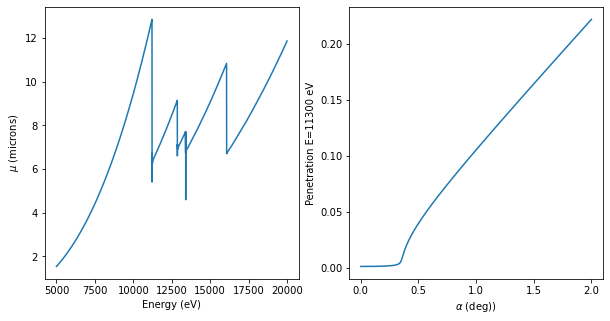

In [3]:
xu_crystal = Crystal.fromCIF('sr2iro4.cif')
E = np.linspace(5000, 20000, 10000)
mu = xu_crystal.absorption_length(E)

alpha = np.linspace(0, 2, 1000)

N = xu_crystal.idx_refraction(en=11.3e3)
Lambda = compute_penetration(E_to_lam(11300), N**2, alpha)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
ax.plot(E, mu)
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('$\mu$ (microns)')

ax = axs[1]
ax.plot(alpha, Lambda)
ax.set_xlabel(r'$\alpha$ (deg))')
ax.set_ylabel('Penetration E=11300 eV')

Text(0, 0.5, 'beta')

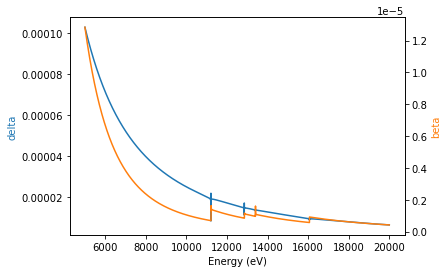

In [4]:
beta = xu_crystal.ibeta(E)
delta = xu_crystal.delta(E)

fig, ax = plt.subplots()

ax.plot(E, delta, color=colors[0])
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('delta', color=colors[0])

axr = ax.twinx()
axr.plot(E, beta, color=colors[1])
axr.set_ylabel('beta', color=colors[1])
#axr.set_ylim(3.8e-7, )

On the resonance there is a peak in $\beta$ and, coming from the Kramers-Kronig, there is a derivative shape in $\delta$. Exactly on the resonace most of the change will be in $\beta$, $\delta$ will have a similar value (just a large derivative).

Furthermore, the x-ray penetration depends primairly on $\beta$. $\delta$ mainly just causes a very small angular change. We can demonstrate this numerically.

In [5]:
E = 11.3e3
alpha = 2
lam = E_to_lam(E)*1e3 # in nm

epsilon = (1 - xu_crystal.delta(E) + 1j*xu_crystal.ibeta(E))**2
Lambda_orig = lam/(4*np.pi*np.imag(np.sqrt(epsilon - cos(alpha)**2)))

epsilon = (1 - xu_crystal.delta(E) + 1j*xu_crystal.ibeta(E)*2)**2
Lambda_double_beta = lam/(4*np.pi*np.imag(np.sqrt(epsilon - cos(alpha)**2)))


epsilon = (1 - 2*xu_crystal.delta(E) + 1j*xu_crystal.ibeta(E))**2
Lambda_double_delta = lam/(4*np.pi*np.imag(np.sqrt(epsilon - cos(alpha)**2)))

print(f"Original {Lambda_orig:.2f}\n"
      f"double beta {Lambda_double_beta:.2f}\n"
      f"double delta {Lambda_double_delta:.2f}")

Original 221.85
double beta 110.92
double delta 218.24


In [6]:
beta_pre = xu_crystal.ibeta(11.2e3)
beta_post = xu_crystal.ibeta(11.25e3)
print(f"beta before {beta_pre} after {beta_post}")

beta before 6.872813217177944e-07 after 1.3964148364405079e-06


Look at Figure 1 of [PHYSICAL REVIEW B 97, 035106 (2018)](https://journals.aps.org/prb/pdf/10.1103/PhysRevB.97.035106)  
This shows that on resonance the XAS (inverse penetration depth~beta) is 2.7 times the step.
We assume that Sr2IrO4 is the same as Sr3Ir2O7 since they have the same valance and very simlar local coodination and interactions.

In [7]:
beta_scaled = beta_pre + (beta_post - beta_pre) *2.7

In [8]:
E = 11.3e3
lam = E_to_lam(E)*1e3 # in nm
delta = xu_crystal.delta(E)
epsilon = (1 - delta + 1j*beta_scaled)**2

alpha = 1.6
Lambda = compute_penetration(lam, epsilon, alpha)
print(f"Sr2IrO4 {E:.2f} eV alpha {alpha:.1f} penetration {Lambda:.1f} nm")

alpha = 2.1
Lambda = compute_penetration(lam, epsilon, alpha)
print(f"Sr2IrO4 {E:.2f} eV alpha {alpha:.1f} penetration {Lambda:.1f} nm")

alpha = 3.7
Lambda = compute_penetration(lam, epsilon, alpha)
print(f"Sr2IrO4 {E:.2f} eV alpha {alpha:.1f} penetration {Lambda:.1f} nm")

Sr2IrO4 11300.00 eV alpha 1.6 penetration 91.4 nm
Sr2IrO4 11300.00 eV alpha 2.1 penetration 121.2 nm
Sr2IrO4 11300.00 eV alpha 3.7 penetration 215.6 nm
